In [6]:
from tqdm import tqdm
import numpy as np
import bs4 as bs
import urllib.request as ur
import pickle
import nltk
import string
import os
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import time
from tqdm import tqdm
import pickle
import string
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
from tqdm._tqdm_notebook import tqdm_notebook
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\48570\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\48570\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\48570\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\48570\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
Using TensorFlow backend.


## Scraping information about articles from investing.com

In [ ]:
n = 4 #How many main pages to scrap - define here

url_common = 'https://www.investing.com/news/stock-market-news/'

dates =[]
source = [] #Source
topics = [] #Topic
links = [] #Linki
short_content = []

for i in tqdm(range(1,n)):
    try: 
        req = ur.Request(url_common + str(i),headers={'User-Agent': 'Chrome/78'}) 
        html = ur.urlopen(req).read() 
    except:
        pass
    parsed = bs.BeautifulSoup(html,'lxml')
    articles = parsed.find('div', {"class":'largeTitle'})
    news  = articles.findAll('article', {"class":"js-article-item articleItem"})
    news1 = articles.findAll('article', {"data-content-type":"news"})
    for n in news:
        topics.append(n.find('a', {'class':'title'}).text)
        dates.append(n.find('span', {'class':'date'}).text[3:])
        links.append(n.find('a').get('href'))
    for n in news1:
        topics.append(n.find('a', {'class':'title'}).text)
        dates.append(n.find('span', {'class':'date'}).text[3:])
        links.append(n.find('a').get('href'))


## Scraping content of atricles

In [ ]:
m = 0

for i in tqdm(links):
    if i[:3] !='htt':
        url_common = 'https://www.investing.com/'
    else:
        url_common = ''
    try:
        req = ur.Request(url_common + i,headers={'User-Agent': 'Chrome/78'})
        html = ur.urlopen(req).read()
    except:
        pass
    parsed = bs.BeautifulSoup(html,'lxml')
    paragraphs = parsed.find_all('p')
    data = []
    for p in paragraphs:
        data.append(p.text)
    df.iloc[m,2] = data
    m = m+1

## Scraping the biggest comapany in every sector

In [2]:
# declare lists to store the data
name = []
link = []
symbol = []
sector = []
industries = ['ms_basic_materials', 'ms_communication_services', 'ms_consumer_cyclical', 'ms_consumer_defensive',
              'ms_energy', 'ms_financial_services', 'ms_healthcare', 'ms_industrials', 'ms_real_estate',
              'ms_technology', 'ms_utilities']

for ind in tqdm(industries):
    url = 'https://finance.yahoo.com/screener/predefined/' + str(ind)
    req = requests.get(str(url)+'?offset=0&count=10',headers={'User-Agent': 'Chrome/78'})
    parsed = bs.BeautifulSoup(req.content)
    sectors = parsed.find("h1", "Fw(b) Fz(17px) D(ib)").text
    tr_list = parsed.findAll("tr", "simpTblRow")[:1]
    for i in tr_list:
        names = i.find('a').get('title')
        name.append(names)
        lnk = i.find('a').get('href')
        links = 'https://finance.yahoo.com' + lnk
        link.append(links)
        symbols = i.find('a').text
        symbol.append(symbols)
        sector.append(sectors)
        
dictio = {'symbol': symbol, 'name': name, 'link':link, 'sector':sector}
df_industries = pd.DataFrame(dictio)
df_industries.drop_duplicates(subset='name', keep='first', inplace=True)
df_industries.drop_duplicates(subset='symbol', keep='first', inplace=True)
df_industries.reset_index(inplace = True, drop = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.22it/s]


In [3]:
df_industries

,symbol,name,link,sector
0,BHP,BHP Group,https://finance.yahoo.com/quote/BHP?p=BHP,Basic Materials Sector
1,GOOGL,Alphabet Inc.,https://finance.yahoo.com/quote/GOOGL?p=GOOGL,Communication Services Sector
2,AMZN,"Amazon.com, Inc.",https://finance.yahoo.com/quote/AMZN?p=AMZN,Consumer Cyclical Sector
3,WMT,Walmart Inc.,https://finance.yahoo.com/quote/WMT?p=WMT,Consumer Defensive Sector
4,XOM,Exxon Mobil Corporation,https://finance.yahoo.com/quote/XOM?p=XOM,Energy Services Sector
5,HSBC-PA,HSBC Holdings plc ADR A 1/40PF A,https://finance.yahoo.com/quote/HSBC-PA?p=HSBC-PA,Financial Services Sector
6,JNJ,Johnson & Johnson,https://finance.yahoo.com/quote/JNJ?p=JNJ,Healthcare Sector
7,LMT,Lockheed Martin Corporation,https://finance.yahoo.com/quote/LMT?p=LMT,Industrials Services Sector
8,AMT,American Tower Corporation (REIT),https://finance.yahoo.com/quote/AMT?p=AMT,Real Estate Sector
9,MSFT,Microsoft Corporation,https://finance.yahoo.com/quote/MSFT?p=MSFT,Technology Services Sector


In [2]:
with open('df', 'rb') as f:
    data_all = pickle.load(f)

## Preprocessing

In [ ]:
words = ['Keep Me Logged In', 'Advertisement', 'Login  Join ','\xa0', 'Got a confidential news tip? We want to hear from you.',
 'Sign up for free newsletters and get more CNBC delivered to your inbox',
 'Get this delivered to your inbox, and more info about our products and services.\xa0',
 '© 2020 CNBC LLC. All Rights Reserved. A Division of NBCUniversal',
 'Data is a real-time snapshot *Data is delayed at least 15 minutes. Global Business and Financial News, Stock Quotes, and Market Data and Analysis.',
 'Data also provided by ', 'Copyright © 2020 MarketWatch, Inc. All rights reserved.',
 '\n                By using this site you agree to the\n                Subscriber Agreement & Terms of Use Updated 03/26/2020\n\nPrivacy Notice and\n                Cookie Notice.\n',
 'Do Not Sell My Personal Information.',
 '\n          Intraday Data provided by FACTSET and subject to terms of use.\n          Historical and current end-of-day data provided by FACTSET.\n          All quotes are in local exchange time.\n          Real-time last sale data for U.S. stock quotes reflect trades reported through Nasdaq only.\n          Intraday data delayed at least 15 minutes or per exchange requirements.\n        ',
 'Create your free account',
 'Already have an account? Login',
 'By creating an account, you agree to theTerms of Service and acknowledge our Privacy Policy.',
 'Log in to your account',
 "Don't have a Benzinga account? Create one", '© 2020 Benzinga.com. Benzinga does not provide investment advice. All rights reserved.', '\n31/03/2020','© Copyright of Globes Publisher Itonut (1983) Ltd. 2020',  'Share with your friends ',
 'BREAKING NEWS',
 'ANALYTICS',
 'COINS',
 '\xa0',
 '\xa0',
 'ICO / STO / IEO',
 'MINING',
 'SHOP',
 'No results matched your search',
 'EXCHANGES',
 'WALLETS',
 'Copyright © 2020 CryptoDaily™', 'Your email address will not be published. Required fields are marked *', 'That...\n  ',
 'WSJ Membership',
 'Customer Service',
 'Tools & Features',
 'Ads',
 'More', '\n31/03/2020 ',
 '\n20/03/2020 ',
 '\n20/03/2020 ',
 '\n20/03/2020 ',
 '\n19/03/2020 ',
 '\n19/03/2020 ',
 '\n18/03/2020 ',
 '\n18/03/2020 ', 'WIRED is where tomorrow is realized. It is the essential source of information and ideas that make sense of a world in constant transformation. The WIRED conversation illuminates how technology is changing every aspect of our lives—from culture to business, science to design. The breakthroughs and innovations that we uncover lead to new ways of thinking, new connections, and new industries.',
 'More From WIRED',
 'Contact',
 '© 2020 Condé Nast. All rights reserved. Use of this site constitutes acceptance of our User Agreement (updated 1/1/20) and Privacy Policy and Cookie Statement (updated 1/1/20) and Your California Privacy Rights. Do Not Sell My Personal Information Wired may earn a portion of sales from products that are purchased through our site as part of our Affiliate Partnerships with retailers. The material on this site may not be reproduced, distributed, transmitted, cached or otherwise used, except with the prior written permission of Condé Nast. Ad Choices',
 'Article Info', 'Supported by', "Copyright © 2020. Market data provided is at least 10-minutes delayed and hosted by Barchart Solutions.Information is provided 'as-is' and solely for informational purposes, not for trading purposes or advice, and is delayed. To see all exchange delays and terms of use, please see disclaimer.",
 'Related Links:']
  
for i in list(data):
    if i in words:
    data.remove(i)
print(data)

In [3]:
def remove(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data_all["content"] = data_all["content"].apply(lambda x: remove_punct(x))
data_all.head(10)

,dates,links,content
0,"Apr 01, 2020",/news/stock-market-news/hsbc-standard-chartere...,No results matched your searchBy Gina Lee Inve...
1,"Apr 01, 2020",/news/coronavirus/apple-doubles-china-donation...,No results matched your searchSHANGHAI (Reuter...
2,"Apr 01, 2020",/news/stock-market-news/china-developers-raise...,No results matched your searchBy Clare Jim and...
3,"Apr 01, 2020",https://invst.ly/qb2dk,AdvertisementSupported byDealBook Newsletter W...
4,"Apr 01, 2020",https://invst.ly/qb26c,"To revisit this article, select My⁠ ⁠Account, ..."
5,"Apr 01, 2020",https://invst.ly/qb20c,Fashion clothing retailer Express Inc.\n ...
6,"Apr 01, 2020",https://invst.ly/qb200,"BorgWarner Inc.\n BWA, \n -.%\n ..."
7,"Apr 01, 2020",https://invst.ly/qb1w3,"British American Tobacco\n BTI, \n ..."
8,"Apr 01, 2020",https://invst.ly/qb1vw,"Ahead of Wisconsin’s primary on Tuesday, Democ..."
9,"Apr 01, 2020",https://invst.ly/qb1s4,"Keros Therapeutics\n KROS, \n \n..."


In [4]:
del data_all['links']

In [5]:
len(data_all)

15893

In [6]:
data_all.drop_duplicates(keep='first',inplace=True)

In [7]:
len(data_all)

15255

In [8]:
data_all = data_all.replace(np.nan, ' ')

In [9]:
data_all.dates=pd.to_datetime(data_all['dates'])

In [10]:
data_all['content']= data_all['content'].apply(lambda x: str(x))

In [11]:
df_out = data_all.set_index(['dates',data_all.groupby(['dates']).cumcount()+1]).unstack().sort_index(level=1, axis=1)
df_out.columns = df_out.columns.map('{0[0]}_{0[1]}'.format)
df_out.reset_index()

,dates,content_1,content_2,content_3,content_4,content_5,content_6,content_7,content_8,content_9,...,content_313,content_314,content_315,content_316,content_317,content_318,content_319,content_320,content_321,content_322
0,2019-09-27,No results matched your searchBy David Shepard...,No results matched your search(Reuters) - Japa...,No results matched your searchBy Alexandra Alp...,No results matched your search(Reuters) - Elec...,No results matched your searchBy Greg Roumelio...,No results matched your searchInvesting.com – ...,No results matched your searchBy Gary McWillia...,No results matched your search(Reuters) - The ...,No results matched your searchBy Joshua Frankl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-09-28,No results matched your search(Reuters) - The ...,No results matched your searchInvesting.com - ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-09-29,No results matched your search(Bloomberg) -- F...,No results matched your searchBy Julie Zhu and...,No results matched your searchInvesting.com - ...,No results matched your searchBy Echo Wang and...,No results matched your searchBy Philip Blenki...,No results matched your searchBy Nichola Samin...,No results matched your searchInvesting.com – ...,No results matched your search(Reuters) - Boe...,No results matched your searchBy Patpicha Tana...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-09-30,No results matched your search(Reuters) - The ...,No results matched your searchBy Moira Warburt...,No results matched your searchNEW YORK (Reuter...,No results matched your searchBy Brendan Piers...,No results matched your searchBy Huw JonesLOND...,No results matched your searchBy Anirban Sen(R...,No results matched your searchWASHINGTON (Reut...,No results matched your searchWASHINGTON (Reut...,No results matched your searchWASHINGTON (Reut...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-10-01,No results matched your search(Bloomberg) -- N...,No results matched your searchBy Paulina Duran...,No results matched your searchInvesting.com - ...,No results matched your searchBy Shubham Kalia...,No results matched your searchHONG KONG (Reute...,No results matched your searchBy Katanga Johns...,No results matched your search(Reuters) - Juul...,No results matched your searchHOUSTON (Reuters...,No results matched your searchBy David Shepard...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,2020-03-28,No results matched your searchMEXICO CITY (Reu...,No results matched your search(Reuters) - Will...,No results matched your searchBy Krystal Hu(Re...,No results matched your search(Reuters) - OneW...,"AdvertisementSupported byDr. Anthony Fauci, th...",Governments and investors woke up too late to ...,Keep Me Logged InThe stock market has gone so ...,Banks and financial-technology firms are start...,Keep Me Logged InMedical staffing firms are ra...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
184,2020-03-29,No results matched your search(Bloomberg) -- I...,No results matched your searchBy David Shepard...,No results matched your search(Reuters) - The ...,No results matched your searchBy David Shepard...,No results matched your searchBy Gina LeeInves...,No results matched your searchBy Jamie FreedSY...,No results matched your searchTOKYO (Reuters) ...,No results matched your search(Bloomberg) -- S...,No results matched your searchMILAN (Reuters) ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185,2020-03-30,No results matched your search By Gina LeeInve...,No results matched your search(Reuters) - The ...,No results matched your searchBy Rachit Vats a...,No results matched your searchBy Jane Lanhee L...,No results matched your searchBy Tracy Rucinsk...,No results matched your searchBy Julie Steenhu...,No results matched your searchBy David Shepard...,No results matched your search(Reuters) - Lend...,No results matched your searchBy Joshua Fran

## Scraping historical data

In [13]:
from datetime import datetime, timedelta
from io import StringIO
import requests
import pandas as pd
import re


class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

#requesting crumb and cookie
    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

#requesting data
    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [14]:
df_v = YahooFinanceHistory('BHP', days_back=191).get_quote()

In [15]:
df_v = df_v.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [16]:
df_v.sort_values(by='Date')

,Date,Close
0,2019-09-30,49.380001
1,2019-10-01,49.009998
2,2019-10-02,47.680000
3,2019-10-03,47.869999
4,2019-10-04,48.410000
...,...,...
126,2020-03-31,36.689999
127,2020-04-01,35.869999
128,2020-04-02,37.900002
129,2020-04-03,36.590000


In [17]:

df_v = df_v.rename({'Date' : 'dates'}, axis=1) 

In [18]:
df_v.Date=pd.to_datetime(df_v['dates'])

C:\Users\48570\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [19]:
df3 = pd.merge(df_v,df_out,on='dates')

## Sentiment analysis

In [7]:
Anakin = SentimentIntensityAnalyzer()

Anakin.polarity_scores(" ")

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [9]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)['compound']
    return(score)

In [17]:
sentiment_analyzer_scores("Although a down market — spurred on by Friday’s jobs report — has Microsoft stock down about 1.5% on April 3, it remains about the only thing working. Even the dividend, 51 cents per share, looks payable. Its yield of 1.3% is close to that of the 30-year U.S. Treasury bond. Simple. The cloud. Not just the cloud, but cloud applications. These are the vital services that let millions work from home, that keep the economy alive. And these are the services seriously helping Microsoft stock right now.")

0.8381

In [23]:
cols = []
for i in range(1,323):
    col = ("content_{}".format(i))
    cols.append(col)


In [24]:
for col in tqdm(cols):
    df3[col]= df3[col].apply(lambda x: str(x))

100%|██████████████████████████████████████████████████████████████████████████████| 322/322 [00:00<00:00, 2935.06it/s]


In [25]:
    
for col in tqdm(cols):
    df3[col]= df3[col].apply(lambda x: sentiment_analyzer_scores(x))

100%|████████████████████████████████████████████████████████████████████████████████| 322/322 [04:26<00:00,  1.21it/s]


In [27]:
df3

,dates,Close,content_1,content_2,content_3,content_4,content_5,content_6,content_7,content_8,...,content_313,content_314,content_315,content_316,content_317,content_318,content_319,content_320,content_321,content_322
0,2019-09-30,49.380001,0.9764,-0.8871,0.6588,-0.4011,0.9680,0.6063,0.6360,0.7500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-10-01,49.009998,-0.7649,-0.6906,-0.9813,-0.8610,-0.9670,0.9845,0.9737,0.8080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-10-02,47.680000,0.6793,-0.7840,0.8511,0.9945,0.9916,0.9756,0.9840,-0.9964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-10-03,47.869999,-0.7537,0.7712,0.8356,0.9134,0.5502,-0.8762,0.9571,0.6466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-10-04,48.410000,-0.2584,-0.9450,0.5707,0.2003,-0.9563,0.9688,0.9259,0.8268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2020-03-26,37.849998,0.7177,0.9501,0.7506,0.9918,0.9923,0.9632,0.9848,0.9930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,2020-03-27,35.590000,0.3382,-0.9684,0.7521,0.8881,0.4753,0.9823,0.9449,-0.4574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,2020-03-30,37.049999,-0.9329,-0.8687,-0.8071,0.9843,0.7345,0.9980,0.9432,0.6696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,2020-03-31,36.689999,0.9348,-0.2018,0.9893,0.9746,0.9624,0.5843,0.8016,-0.7139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
weighted_comp = []
for i in range(0,len(df3)):
    a = df3.loc[i,cols].tolist()
    n = 0
    i= 0 
    length = len(a)  
    while(i<length):
        if(a[i]==n):
            a.remove(a[i])
            length = length -1  
            continue
        i = i+1
    weighted_comp.append(np.average(a))

df3['compound_mean'] = weighted_comp
df3 = df3.drop(cols, axis=1)

## Creating label of "up" and "down" for prices for next day

In [29]:
df3['label'] = ''

In [31]:
#label oznacza, czy cena akcji tego dnia wzrośsła czy spadła
#tutaj tak samo error, ale się label dobrze robi, więc czill xd
m = 1
for i in df3.Close:
    if i < df3.Close[m]:
        df3.label[m-1] = 1
    else:
        df3.label[m-1] = 0
    m = m+1

C:\Users\48570\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\48570\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KeyError: 128

In [36]:
df3.drop(df3.index[127], inplace = True)

In [37]:
df3

,dates,Close,compound_mean,label
0,2019-09-30,49.380001,0.431213,0
1,2019-10-01,49.009998,0.146505,0
2,2019-10-02,47.680000,0.211254,1
3,2019-10-03,47.869999,0.352498,1
4,2019-10-04,48.410000,0.387687,0
...,...,...,...,...
122,2020-03-25,37.320000,0.584710,1
123,2020-03-26,37.849998,0.571708,0
124,2020-03-27,35.590000,0.507320,1
125,2020-03-30,37.049999,0.438026,0


In [44]:
with open('df3', 'wb') as f:
    pickle.dump(df3,f)

In [2]:
with open('df3', 'rb') as f:
    df = pickle.load(f)

## Machine learning baseline

In [3]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.asarray(df[['compound_mean', 'Close']])
Y = np.asarray(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [9]:
model = Sequential()
model.add(Dense(16, input_shape=(2,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30,
                    validation_data= (X_test,y_test))

Train on 95 samples, validate on 32 samples
Epoch 1/30
95/95 [==============================] - 0s 3ms/step - loss: 1.1999 - accuracy: 0.5368 - val_loss: 0.8169 - val_accuracy: 0.4062
Epoch 2/30
95/95 [==============================] - 0s 340us/step - loss: 1.7436 - accuracy: 0.4737 - val_loss: 1.1396 - val_accuracy: 0.4062
Epoch 3/30
95/95 [==============================] - 0s 239us/step - loss: 1.3991 - accuracy: 0.4947 - val_loss: 0.6761 - val_accuracy: 0.5938
Epoch 4/30
95/95 [==============================] - 0s 220us/step - loss: 0.8395 - accuracy: 0.5895 - val_loss: 0.7001 - val_accuracy: 0.5938
Epoch 5/30
95/95 [==============================] - 0s 220us/step - loss: 1.1634 - accuracy: 0.4632 - val_loss: 0.6839 - val_accuracy: 0.5938
Epoch 6/30
95/95 [==============================] - 0s 231us/step - loss: 0.9303 - accuracy: 0.5158 - val_loss: 0.8573 - val_accuracy: 0.4062
Epoch 7/30
95/95 [==============================] - 0s 220us/step - loss: 1.1117 - accuracy: 0.5158 - val_

In [11]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 62us/step


[0.6868644952774048, 0.59375]

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.asarray(df[['compound_mean']])
Y = np.asarray(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [37]:
model = Sequential()
model.add(Dense(16, input_shape=(1,) ))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30,
                    validation_data= (X_test,y_test))

Train on 95 samples, validate on 32 samples
Epoch 1/30
95/95 [==============================] - 1s 6ms/step - loss: 0.6927 - accuracy: 0.5263 - val_loss: 0.6927 - val_accuracy: 0.5625
Epoch 2/30
95/95 [==============================] - 0s 267us/step - loss: 0.6945 - accuracy: 0.4842 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 3/30
95/95 [==============================] - 0s 273us/step - loss: 0.6908 - accuracy: 0.5368 - val_loss: 0.6930 - val_accuracy: 0.5312
Epoch 4/30
95/95 [==============================] - 0s 241us/step - loss: 0.6929 - accuracy: 0.4842 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch 5/30
95/95 [==============================] - 0s 241us/step - loss: 0.6910 - accuracy: 0.5158 - val_loss: 0.6933 - val_accuracy: 0.5312
Epoch 6/30
95/95 [==============================] - 0s 273us/step - loss: 0.6926 - accuracy: 0.5158 - val_loss: 0.6934 - val_accuracy: 0.5312
Epoch 7/30
95/95 [==============================] - 0s 252us/step - loss: 0.6969 - accuracy: 0.5053 - val_

In [38]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 92us/step


[0.6920510530471802, 0.53125]

## LSTM

In [129]:
params = {"batch_size": 2,  
    "epochs": 500,
    "lr": 0.00010000,
    "time_steps": 5}

In [130]:
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [131]:
def trim_dataset(mat,batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [132]:
def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    return x, y

In [133]:
train_cols = ["Close",'compound_mean']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [134]:
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

dim_0 96


In [135]:
x_temp, y_temp = build_timeseries(x_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


dim_0 21


In [137]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                    dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                    kernel_initializer='random_uniform'))
model.add(Dropout(0.2))
model.add(LSTM(60, dropout=0.0))
model.add(Dropout(0.1))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=params["lr"])
model.compile(loss='mean_squared_error', optimizer=optimizer)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
mcp = ModelCheckpoint(os.path.join("best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
    
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp])

Train on 96 samples, validate on 10 samples
Epoch 1/500
 - 2s - loss: 0.0697 - val_loss: 2.7330

Epoch 00001: val_loss improved from inf to 2.73298, saving model to best_model.h5
Epoch 2/500
 - 1s - loss: 0.0681 - val_loss: 2.7275

Epoch 00002: val_loss improved from 2.73298 to 2.72748, saving model to best_model.h5
Epoch 3/500
 - 1s - loss: 0.0664 - val_loss: 2.7181

Epoch 00003: val_loss improved from 2.72748 to 2.71806, saving model to best_model.h5
Epoch 4/500
 - 1s - loss: 0.0637 - val_loss: 2.7051

Epoch 00004: val_loss improved from 2.71806 to 2.70510, saving model to best_model.h5
Epoch 5/500
 - 1s - loss: 0.0604 - val_loss: 2.6907

Epoch 00005: val_loss improved from 2.70510 to 2.69073, saving model to best_model.h5
Epoch 6/500
 - 1s - loss: 0.0579 - val_loss: 2.6728

Epoch 00006: val_loss improved from 2.69073 to 2.67276, saving model to best_model.h5
Epoch 7/500
 - 1s - loss: 0.0571 - val_loss: 2.6520

Epoch 00007: val_loss improved from 2.67276 to 2.65202, saving model to b


Epoch 00062: val_loss improved from 1.76121 to 1.75873, saving model to best_model.h5
Epoch 63/500
 - 1s - loss: 0.0200 - val_loss: 1.7514

Epoch 00063: val_loss improved from 1.75873 to 1.75139, saving model to best_model.h5
Epoch 64/500
 - 1s - loss: 0.0223 - val_loss: 1.7605

Epoch 00064: val_loss did not improve from 1.75139
Epoch 65/500
 - 1s - loss: 0.0213 - val_loss: 1.7608

Epoch 00065: val_loss did not improve from 1.75139
Epoch 66/500
 - 1s - loss: 0.0197 - val_loss: 1.7568

Epoch 00066: val_loss did not improve from 1.75139
Epoch 67/500
 - 1s - loss: 0.0208 - val_loss: 1.7536

Epoch 00067: val_loss did not improve from 1.75139
Epoch 68/500
 - 1s - loss: 0.0194 - val_loss: 1.7548

Epoch 00068: val_loss did not improve from 1.75139
Epoch 69/500
 - 1s - loss: 0.0203 - val_loss: 1.7520

Epoch 00069: val_loss did not improve from 1.75139
Epoch 70/500
 - 1s - loss: 0.0203 - val_loss: 1.7487

Epoch 00070: val_loss improved from 1.75139 to 1.74865, saving model to best_model.h5
Epo

 - 1s - loss: 0.0160 - val_loss: 1.7326

Epoch 00137: val_loss did not improve from 1.69650
Epoch 138/500
 - 1s - loss: 0.0136 - val_loss: 1.7241

Epoch 00138: val_loss did not improve from 1.69650
Epoch 139/500
 - 1s - loss: 0.0166 - val_loss: 1.7453

Epoch 00139: val_loss did not improve from 1.69650
Epoch 140/500
 - 1s - loss: 0.0154 - val_loss: 1.7029

Epoch 00140: val_loss did not improve from 1.69650
Epoch 141/500
 - 1s - loss: 0.0144 - val_loss: 1.7005

Epoch 00141: val_loss did not improve from 1.69650
Epoch 142/500
 - 1s - loss: 0.0165 - val_loss: 1.7193

Epoch 00142: val_loss did not improve from 1.69650
Epoch 143/500
 - 1s - loss: 0.0164 - val_loss: 1.7021

Epoch 00143: val_loss did not improve from 1.69650
Epoch 144/500
 - 1s - loss: 0.0134 - val_loss: 1.7029

Epoch 00144: val_loss did not improve from 1.69650
Epoch 145/500
 - 1s - loss: 0.0140 - val_loss: 1.7057

Epoch 00145: val_loss did not improve from 1.69650
Epoch 146/500
 - 1s - loss: 0.0149 - val_loss: 1.6956

Epoch

In [138]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Mean Squared Error is", error, y_pred.shape, y_test_t.shape)

Mean Squared Error is 2.1969629402141755 (10,) (10,)


In [139]:
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]

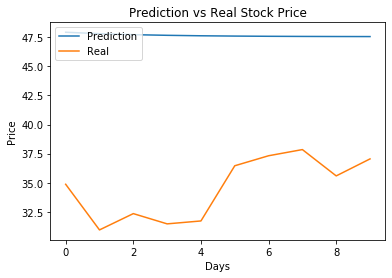

In [140]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [141]:
from datetime import datetime, timedelta
from io import StringIO
import requests
import pandas as pd


class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [144]:
df_ge = YahooFinanceHistory('GE', days_back=15000).get_quote()

In [145]:
df_ge

,Date,Open,High,Low,Close,Adj Close,Volume
0,1979-03-14,0.944010,0.949018,0.941506,0.944010,0.003767,2960200
1,1979-03-15,0.944010,0.956530,0.944010,0.949018,0.003787,5191600
2,1979-03-16,0.949018,0.961538,0.944010,0.961538,0.003837,7418100
3,1979-03-19,0.961538,0.971554,0.956530,0.966546,0.003857,5381300
4,1979-03-20,0.966546,0.969050,0.956530,0.959034,0.003827,4662500
...,...,...,...,...,...,...,...
10351,2020-03-31,7.870000,8.180000,7.820000,7.940000,7.940000,121149900
10352,2020-04-01,7.520000,7.550000,7.000000,7.040000,7.040000,99556900
10353,2020-04-02,7.020000,7.390000,6.770000,6.900000,6.900000,97498400
10354,2020-04-03,7.030000,7.050000,6.580000,6.730000,6.730000,97803300


In [146]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 50,
    "lr": 0.00010000,
    "time_steps": 60
}

In [147]:
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

In [148]:
def trim_dataset(mat,batch_size):
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [149]:
def build_timeseries(mat, y_col_index):
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    return x, y

In [150]:
train_cols = ["Close"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [151]:
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [152]:
x_t, y_t = build_timeseries(x_train, 0)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

dim_0 8224


In [153]:
x_temp, y_temp = build_timeseries(x_test, 0)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 2012


In [155]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                    dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                    kernel_initializer='random_uniform'))
model.add(Dropout(0.4))
model.add(LSTM(60, dropout=0.0))
model.add(Dropout(0.4))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=params["lr"])
model.compile(loss='mean_squared_error', optimizer=optimizer)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
mcp = ModelCheckpoint(os.path.join("best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
    
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp])

Train on 8220 samples, validate on 1000 samples
Epoch 1/50
 - 47s - loss: 0.0274 - val_loss: 0.0142

Epoch 00001: val_loss improved from inf to 0.01422, saving model to best_model.h5
Epoch 2/50
 - 45s - loss: 0.0034 - val_loss: 0.0159

Epoch 00002: val_loss did not improve from 0.01422
Epoch 3/50
 - 45s - loss: 0.0023 - val_loss: 0.0180

Epoch 00003: val_loss did not improve from 0.01422
Epoch 4/50
 - 46s - loss: 0.0020 - val_loss: 0.0156

Epoch 00004: val_loss did not improve from 0.01422
Epoch 5/50
 - 47s - loss: 0.0020 - val_loss: 0.0150

Epoch 00005: val_loss did not improve from 0.01422
Epoch 6/50
 - 44s - loss: 0.0018 - val_loss: 0.0130

Epoch 00006: val_loss improved from 0.01422 to 0.01304, saving model to best_model.h5
Epoch 7/50
 - 45s - loss: 0.0019 - val_loss: 0.0126

Epoch 00007: val_loss improved from 0.01304 to 0.01260, saving model to best_model.h5
Epoch 8/50
 - 49s - loss: 0.0018 - val_loss: 0.0143

Epoch 00008: val_loss did not improve from 0.01260
Epoch 9/50
 - 48s -

In [156]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Mean Squared Error is", error, y_pred.shape, y_test_t.shape)

Mean Squared Error is 0.0010670566073682428 (1000,) (1000,)


In [157]:
y_pred_org = (y_pred * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]
y_test_t_org = (y_test_t * min_max_scaler.data_range_[0]) + min_max_scaler.data_min_[0]

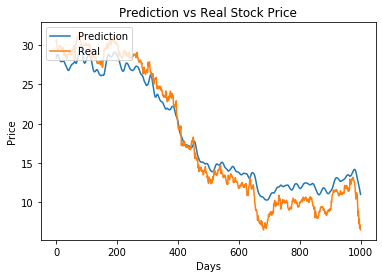

In [158]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')